<a href="https://colab.research.google.com/github/Aarthi-N/Airline-Flight-Delays/blob/main/airline_flight_delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

In [ ]:
import zipfile
import pandas as pd
import os
from pyspark.sql import SparkSession

In [ ]:

zip_path = '/content/Airlines+Airports+Cancellation+Codes+&+Flights.zip'
extract_path = '/content/data'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("AirlineData").getOrCreate()

airlines = spark.read.csv(f"{extract_path}/airlines.csv", header=True, inferSchema=True)
airports = spark.read.csv(f"{extract_path}/airports.csv", header=True, inferSchema=True)
cancel_codes = spark.read.csv(f"{extract_path}/cancellation_codes.csv", header=True, inferSchema=True)
flights = spark.read.csv(f"{extract_path}/flights.csv", header=True, inferSchema=True)


In [ ]:
from pyspark.sql.functions import col, sum
merged_df = flights.join(airlines, flights.AIRLINE == airlines.IATA_CODE, "left")

merged_df = merged_df.join(airports.withColumnRenamed("IATA_CODE", "ORIGIN_CODE")
                           .withColumnRenamed("AIRPORT", "ORIGIN_AIRPORT_NAME")
                           .withColumnRenamed("CITY", "ORIGIN_CITY")
                           .withColumnRenamed("STATE", "ORIGIN_STATE")
                           .withColumnRenamed("COUNTRY", "ORIGIN_COUNTRY")
                           .withColumnRenamed("LATITUDE", "ORIGIN_LATITUDE")
                           .withColumnRenamed("LONGITUDE", "ORIGIN_LONGITUDE"),
                           merged_df.ORIGIN_AIRPORT == col("ORIGIN_CODE"), "left")

merged_df = merged_df.join(airports.withColumnRenamed("IATA_CODE", "DEST_CODE")
                           .withColumnRenamed("AIRPORT", "DEST_AIRPORT_NAME")
                           .withColumnRenamed("CITY", "DEST_CITY")
                           .withColumnRenamed("STATE", "DEST_STATE")
                           .withColumnRenamed("COUNTRY", "DEST_COUNTRY")
                           .withColumnRenamed("LATITUDE", "DEST_LATITUDE")
                           .withColumnRenamed("LONGITUDE", "DEST_LONGITUDE"),
                           merged_df.DESTINATION_AIRPORT == col("DEST_CODE"), "left")

merged_df = merged_df.join(cancel_codes, merged_df.CANCELLATION_REASON == cancel_codes.CANCELLATION_REASON, "left")


In [ ]:
merged_df.show(5)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+---------+--------------------+-----------+--------------------+-------------+------------+--------------+---------------+----------------+---------+--------------------+---------------+----------+------------+-------------+--------------+-------------------+------------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR

In [ ]:
columns_to_drop = ["IATA_CODE", "ORIGIN_CODE", "DEST_CODE"]
merged_df = merged_df.drop(*columns_to_drop)

In [ ]:
merged_df = merged_df.dropDuplicates()

In [ ]:
merged_df.show(5)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+--------------------+--------------------+-------------+------------+--------------+---------------+----------------+--------------------+-------------+----------+------------+-------------+--------------+-------------------+------------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLI

**FLIGHT VOLUME BY MONTH**

In [ ]:
flights_by_month = merged_df.groupBy("MONTH").count().orderBy("MONTH")
flights_by_month.show()

+-----+------+
|MONTH| count|
+-----+------+
|    1|469968|
|    2|429191|
|    3|504312|
|    4|485151|
|    5|496993|
|    6|503897|
|    7|520718|
|    8|510536|
|    9|464946|
|   10|486165|
|   11|467972|
|   12|479230|
+-----+------+



**FLIGHT VOLUME BY DAY OF WEEK**

In [ ]:
flights_by_day = merged_df.groupBy("DAY_OF_WEEK").count().orderBy("DAY_OF_WEEK")
flights_by_day.show()

+-----------+------+
|DAY_OF_WEEK| count|
+-----------+------+
|          1|865543|
|          2|844600|
|          3|855897|
|          4|872521|
|          5|862209|
|          6|700545|
|          7|817764|
+-----------+------+



**DATA VISUALIZATION**

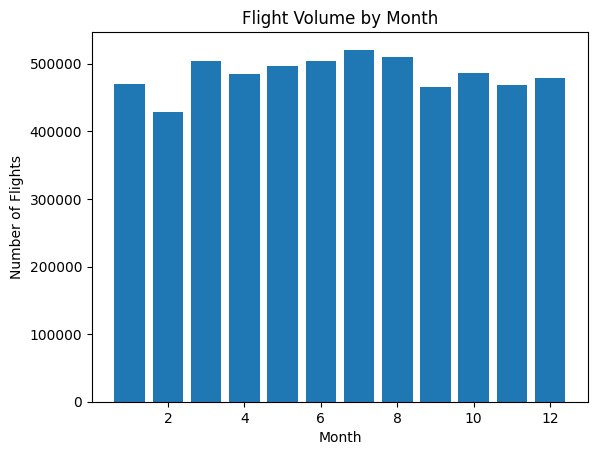

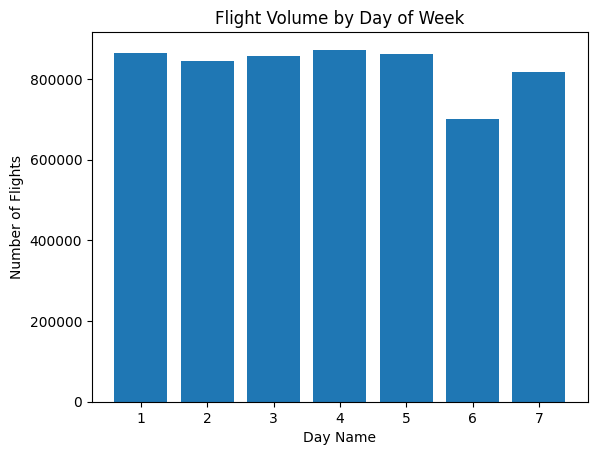

In [ ]:
flights_by_month_pd = flights_by_month.toPandas()
flights_by_day_pd = flights_by_day.toPandas()

import matplotlib.pyplot as plt

plt.bar(flights_by_month_pd["MONTH"], flights_by_month_pd["count"])
plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.title("Flight Volume by Month")
plt.show()

plt.bar(flights_by_day_pd["DAY_OF_WEEK"], flights_by_day_pd["count"])
plt.xlabel("Day Name")
plt.ylabel("Number of Flights")
plt.title("Flight Volume by Day of Week")
plt.show()


**PERCENTAGE OF DELAYED FLIGHTS**

In [ ]:
from pyspark.sql.functions import col, avg

flights_2015 = merged_df.filter(col("YEAR") == 2015)

total_flights = flights_2015.count()

delayed_flights = flights_2015.filter(col("DEPARTURE_DELAY") > 0)
num_delayed = delayed_flights.count()

percentage_delayed = (num_delayed / total_flights) * 100

avg_delay = delayed_flights.agg(avg("DEPARTURE_DELAY")).collect()[0][0]

print(f"Total flights in 2015: {total_flights}")
print(f"Number of delayed flights: {num_delayed}")
print(f"Percentage delayed: {percentage_delayed:.2f}%")
print(f"Average delay (minutes): {avg_delay:.2f}")

Total flights in 2015: 5819079
Number of delayed flights: 2125618
Percentage delayed: 36.53%
Average delay (minutes): 32.67


**% OF DELAYED FLIGHTS BY MONTH**

In [ ]:
from pyspark.sql.functions import col, avg

flights_with_delay_flag = merged_df.withColumn(
    "DELAY_FLAG", (col("DEPARTURE_DELAY") > 0).cast("int")
)

delayed_by_month = flights_with_delay_flag.groupBy("MONTH") \
    .agg(avg("DELAY_FLAG").alias("pct_delayed")) \
    .orderBy("MONTH")

delayed_by_month.show()


+-----+-------------------+
|MONTH|        pct_delayed|
+-----+-------------------+
|    1| 0.3853867788466783|
|    2|0.42392675224621884|
|    3| 0.3926019855248312|
|    4|0.34791993312511177|
|    5|0.36378206757963377|
|    6|0.43493827733900914|
|    7|0.40607232313918146|
|    8|0.37729060114626434|
|    9| 0.2863625172239524|
|   10| 0.2999053378693993|
|   11| 0.3293337618331741|
|   12| 0.4015239072762013|
+-----+-------------------+



**% OF DELAYED FLIGHTS BY MONTH FOR BOSTON**

In [ ]:
bos_flights = flights_with_delay_flag.filter(col("ORIGIN_AIRPORT") == "BOS")

delayed_bos_by_month = bos_flights.groupBy("MONTH") \
    .agg(avg("DELAY_FLAG").alias("pct_delayed")) \
    .orderBy("MONTH")

delayed_bos_by_month.show()


+-----+-------------------+
|MONTH|        pct_delayed|
+-----+-------------------+
|    1| 0.3677600292647238|
|    2| 0.5621293614673838|
|    3| 0.3830049261083744|
|    4|0.33490945674044265|
|    5|0.31734172237514746|
|    6|0.37885631907736667|
|    7| 0.3989781699953553|
|    8|0.40201052236001505|
|    9| 0.2999483737738771|
|   11| 0.2896412651241775|
|   12| 0.3937216756936001|
+-----+-------------------+



**DATA VISUALIZATION**

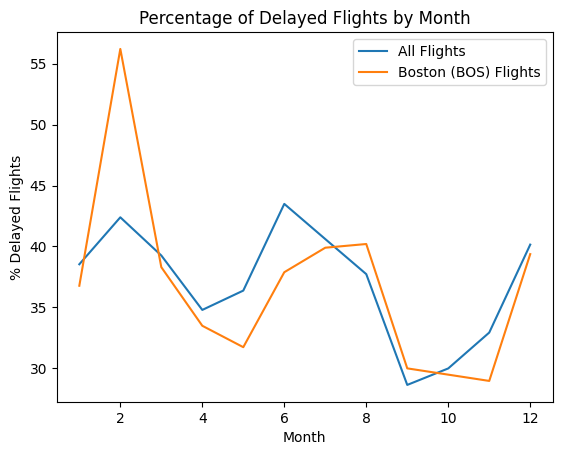

In [ ]:
import matplotlib.pyplot as plt

all_flights_pd = delayed_by_month.toPandas()
bos_flights_pd = delayed_bos_by_month.toPandas()

plt.plot(all_flights_pd["MONTH"], all_flights_pd["pct_delayed"]*100, label="All Flights")
plt.plot(bos_flights_pd["MONTH"], bos_flights_pd["pct_delayed"]*100, label="Boston (BOS) Flights")

plt.xlabel("Month")
plt.ylabel("% Delayed Flights")
plt.title("Percentage of Delayed Flights by Month")
plt.legend()
plt.show()


**COUNT CANCELLED FLIGHTS**

In [ ]:
from pyspark.sql.functions import col, count

flights_2015 = merged_df.filter(col("YEAR") == 2015)

cancelled_flights = flights_2015.filter(col("CANCELLED") == 1)
total_cancelled = cancelled_flights.count()

print(f"Total cancelled flights in 2015: {total_cancelled}")



Total cancelled flights in 2015: 89884


**BREAKDOWN BY CANCELLATION REASON**

In [ ]:
cancel_reason_counts = cancelled_flights.groupBy("CANCELLATION_DESCRIPTION") \
                                        .agg(count("*").alias("count"))

cancel_reason_counts.show()


+------------------------+-----+
|CANCELLATION_DESCRIPTION|count|
+------------------------+-----+
|                Security|   22|
|     National Air System|15749|
|                 Weather|48851|
|         Airline/Carrier|25262|
+------------------------+-----+



**COMPUTE PERCENTAGES**

In [ ]:

reason_counts = {row["CANCELLATION_DESCRIPTION"]: row["count"] for row in cancel_reason_counts.collect()}

pct_weather = (reason_counts.get("B", 0) / total_cancelled) * 100
pct_airline = (reason_counts.get("A", 0) / total_cancelled) * 100

print(f"% due to Weather: {pct_weather:.2f}%")
print(f"% due to Airline/Carrier: {pct_airline:.2f}%")


% due to Weather: 0.00%
% due to Airline/Carrier: 0.00%


**CANCELLATION BREAKDOWN VISUALIZATION**

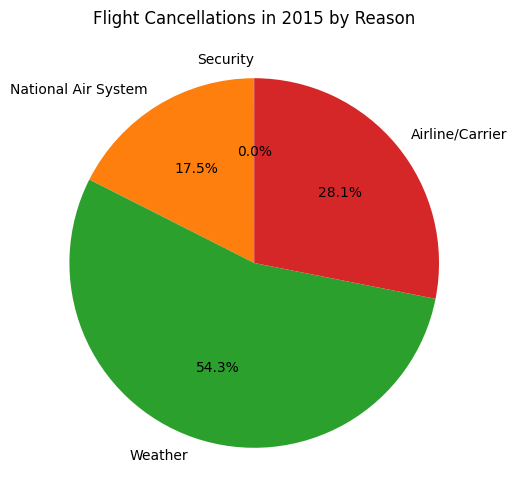

In [ ]:
import matplotlib.pyplot as plt

cancel_reason_pd = cancel_reason_counts.toPandas()

cancel_reason_pd.columns = [col.upper() for col in cancel_reason_pd.columns]

plt.figure(figsize=(6,6))
plt.pie(cancel_reason_pd["COUNT"], labels=cancel_reason_pd["CANCELLATION_DESCRIPTION"], autopct="%1.1f%%", startangle=90)
plt.title("Flight Cancellations in 2015 by Reason")
plt.show()


**RELIABILITY OF FLIGHTS**

In [ ]:
from pyspark.sql import functions as F

airline_reliability = (
    flights.groupBy("AIRLINE")
    .agg(
        F.count("*").alias("total_flights"),
        F.sum(F.when(flights.DEPARTURE_DELAY <= 0, 1).otherwise(0)).alias("on_time_flights")
    )
    .withColumn("on_time_percentage", (F.col("on_time_flights") / F.col("total_flights")) * 100)
    .orderBy("on_time_percentage", ascending=False)
)

airline_reliability.show(truncate=False)


+-------+-------------+---------------+------------------+
|AIRLINE|total_flights|on_time_flights|on_time_percentage|
+-------+-------------+---------------+------------------+
|AS     |172521       |128344         |74.3932622695208  |
|HA     |76272        |55973          |73.38603943780156 |
|OO     |588353       |407514         |69.26352036957405 |
|EV     |571977       |387397         |67.7294716395939  |
|DL     |875881       |589714         |67.32809593997358 |
|US     |198715       |132260         |66.55763279068012 |
|AA     |725984       |469694         |64.69756909243178 |
|MQ     |294632       |186556         |63.31830894132341 |
|VX     |61903        |38006          |61.39605511849183 |
|F9     |90836        |55397          |60.98573252895327 |
|B6     |267048       |160782         |60.20715377010875 |
|NK     |117379       |63365          |53.98325083703218 |
|WN     |1261855      |679322         |53.835187085679415|
|UA     |515723       |252984         |49.05424035771141

In [ ]:

airline_reliability = airline_reliability.join(
    airlines, airline_reliability.AIRLINE == airlines.IATA_CODE, "left"
).select(
    airline_reliability.AIRLINE,
    airlines.AIRLINE.alias("AIRLINE_NAME"),
    "total_flights",
    "on_time_flights",
    "on_time_percentage"
).orderBy("on_time_percentage", ascending=False)

airline_reliability.show(truncate=False)


+-------+----------------------------+-------------+---------------+------------------+
|AIRLINE|AIRLINE_NAME                |total_flights|on_time_flights|on_time_percentage|
+-------+----------------------------+-------------+---------------+------------------+
|AS     |Alaska Airlines Inc.        |172521       |128344         |74.3932622695208  |
|HA     |Hawaiian Airlines Inc.      |76272        |55973          |73.38603943780156 |
|OO     |Skywest Airlines Inc.       |588353       |407514         |69.26352036957405 |
|EV     |Atlantic Southeast Airlines |571977       |387397         |67.7294716395939  |
|DL     |Delta Air Lines Inc.        |875881       |589714         |67.32809593997358 |
|US     |US Airways Inc.             |198715       |132260         |66.55763279068012 |
|AA     |American Airlines Inc.      |725984       |469694         |64.69756909243178 |
|MQ     |American Eagle Airlines Inc.|294632       |186556         |63.31830894132341 |
|VX     |Virgin America         